# Modeling firing neurons based on EEG signals

# Summary



## In this notebook:
- **Basic concepts**
    - Cortical neuron
    - Mathematical neuron model
- **Modeling neurons in motor units based on EEG signals**
    - Importing libraries
    - Loading data
    - Data analysis
    - Defining spiking neuron class
- **Simulating neuron firings**
    - Different preprocessing
        - Raw data
        - Rectified data
    - Different parameters
        - Parameter a
        - Parameter b
        - Parameter d
    - Neuron firing spikes as intensity control
        - Frame preparation
        - Comparing RMS and Number-of-Spikes
    - Modelling nerve bundle
    - Replicating neuron firings
- **Conclusion**

        

# Basic concepts
## Cortical neuron
Cortical neurons, found in the brain's cerebral cortex, are essential players in how we think, remember, and perceive the world around us. The cerebral cortex itself is a complex layer of neural tissue, made up of about 10 to 14 billion neurons, and it's involved in nearly everything that makes us who we are. Because of their crucial role in these processes, primary cortical neurons are incredibly valuable in neurobiology research. Scientists rely on them to explore the brain's intricate workings and to better understand how our minds function, making them a key focus in studies aimed at unraveling the mysteries of the human brain.
![Image](https://i.imgur.com/xOQs8jA.png)

The neocortex, which makes up the majority of the human brain, is a highly structured and organized region that supports complex cognitive functions. Neurons in the neocortex are arranged in layers and columns, each containing a specific type and number of neurons.

There are 5 main classes of neurons:

- Non-Accommodating (NAC): These neurons fire repetitively without frequency adaptation, meaning their firing rate doesn't decrease during prolonged stimuli. Their action potentials are brief, with a deep fast afterhyperpolarization (fAHP).

- Accommodating (AC): These neurons exhibit frequency adaptation during prolonged stimuli, meaning their firing rate decreases over time.

- Stuttering (STUT): These neurons fire in clusters of action potentials separated by periods of silence. The action potentials within a cluster show little to no adaptation, and the duration of the silent periods between clusters is unpredictable.

- Irregular Spiking (IS): These neurons discharge single action potentials randomly during sustained stimuli, showing marked accommodation.

- Bursting (BST): These neurons typically fire a burst of action potentials at the onset of a stimulus, followed by a strong afterhyperpolarization (sAHP). The response can vary from repetitive bursting to a single powerful burst followed by silence.


![Image](https://i.imgur.com/t9zH3t8.png)

![Image](https://i.imgur.com/DMnaXQ9.png)

Source: [Markram, H., Toledo-Rodriguez, M., Wang, Y., Gupta, A., Silberberg, G., & Wu, C. (2004). Interneurons of the neocortical inhibitory system. Nature Reviews Neuroscience, 5(10), 793-807. doi:10.1038/nrn1519](https://www.nature.com/articles/nrn1519)

## Mathematical neuron model
This metod shows simple and effective modeling of neuron firing. It allows us to model different neurons based on the amplitude of EEG. First, we acquire signal from one channel. We apply following algorithm:

![Image](https://i.imgur.com/Pk5U2eW.png)

and spiking, resetting:

![Image](https://i.imgur.com/T1BTJJf.png)

where:

- *v* is voltage, neurons membrane potential at given time
- *v'* is small difference changing with smallest possible quantity of time, described as dv/dt
- *u* is recovery variable , which accounts for the activation of K+ ionic currents and inactivation of N+ ionic currents, and it provides negative feedback to v
- *u'* is small difference changing with smallest possible quantity of time, described as du/dt
- *a* describes time scale of the recovery variable u. Smaller a means slower recovery, default a =  0.01
- *b* describes sensitivity of the recovery variable u to the subthreshold fluctuations of membrane potential v. Bigger b couples v and u more, default b = 0.2
- *c* is default starting point and after-spike reset value of membrane potential v, default c = -65 mV
- *d* describes after-spike reset of the recovery variable u caused by slow high-thresholds Na+ and K+ conductances, default d = 2
- *I* is input value at current time. Usually it is defined in amps or miliamps, in our case it is amplitude of EEG signal

Different parameters create different neuron behavior. Such table is show below.

![Image](https://i.imgur.com/ZGUkAwm.png)

 A possible extension of the model is to treat u, a and b as vectors, and use sum(u) instead of u in the voltage. This accounts for slow conductances with multiple time scales. Additionally  if one is interested in the behavior of a single neuron, then other choices of the function are available, and sometimes more preferable. For example, the function 0.04v^2+4.1v+108 with b = 0.1 is a better choice for the RS neuron, since it leads to the saddle-node on invariant circle bifurcation and Class 1 excitability. For more information:

Source: [Simple Model of Spiking Neurons by Eugene M. Izhikevich](https://www.izhikevich.org/publications/spikes.pdf)

# Project

## Importing libraries

In [359]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats

%matplotlib inline

## Loading data

In [360]:
def load_examples(num_examples=6, base_filename="example"):
    dataframes = []

    for i in range(1, num_examples + 1):
        filename = f"data/{base_filename}{i}.csv"
        df = pd.read_csv(filename)
        dataframes.append(df)
        print(f"Loaded {filename}")

    return dataframes

example_dataframes = load_examples()

df1 = example_dataframes[0]
df2 = example_dataframes[1]
df3 = example_dataframes[2]
df4 = example_dataframes[3]
df5 = example_dataframes[4]
df6 = example_dataframes[5]

Loaded data/example1.csv
Loaded data/example2.csv
Loaded data/example3.csv
Loaded data/example4.csv
Loaded data/example5.csv
Loaded data/example6.csv


In [361]:
df1.head()

,time,EEG_amplitude
0,0,3.924905
1,1,4.924905
2,2,2.924905
3,3,1.924905
4,4,-6.075095


## Data analysis

In [362]:
df1.isnull().values.any() #Checking for null values

False

In [363]:
df5.describe().transpose() #Information about dataset

,count,mean,std,min,25%,50%,75%,max
time,1000.0,499.50000,288.819436,0.00,249.75,499.50,749.25,999.00
EEG_amplitude,1000.0,-82.34613,19.660065,-155.04,-94.86,-81.09,-69.87,-22.44


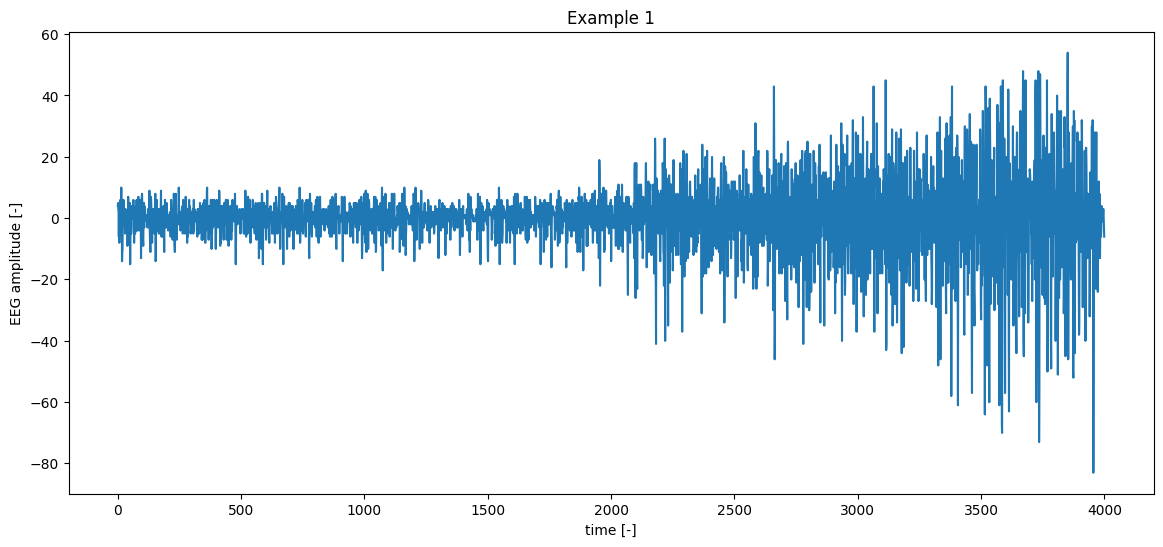

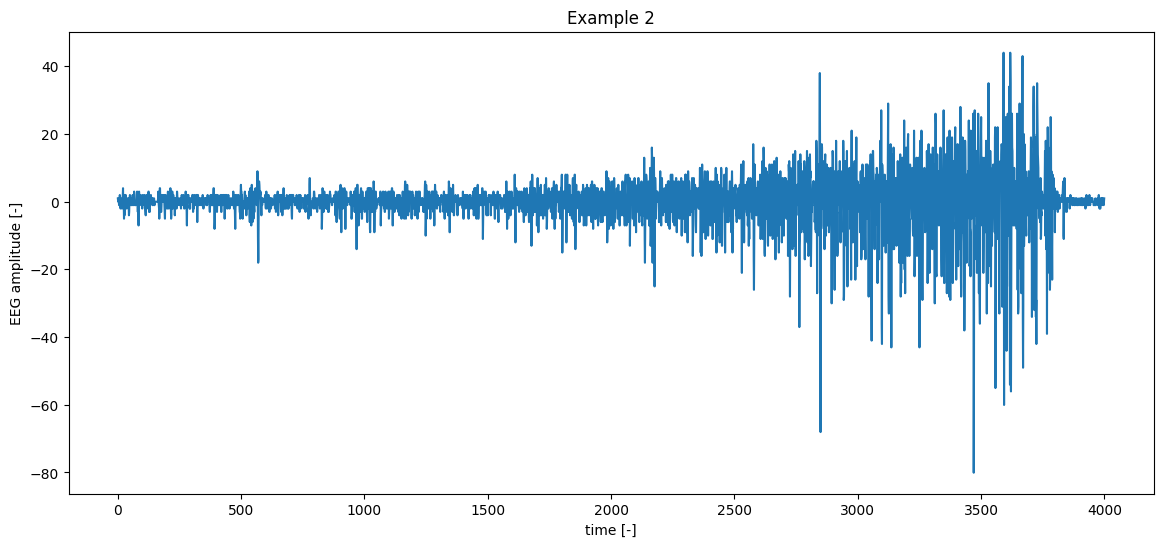

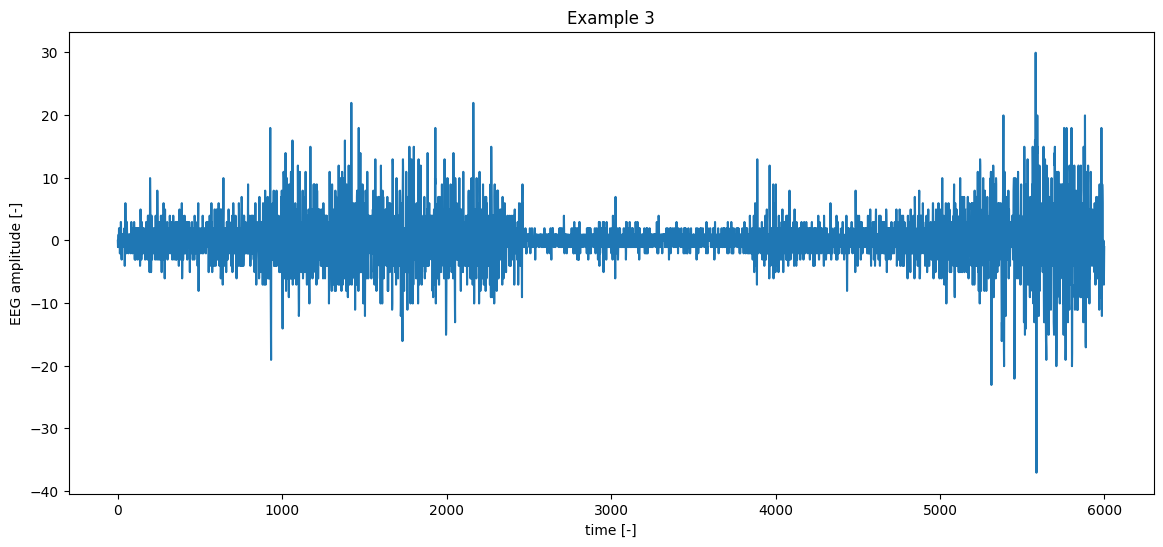

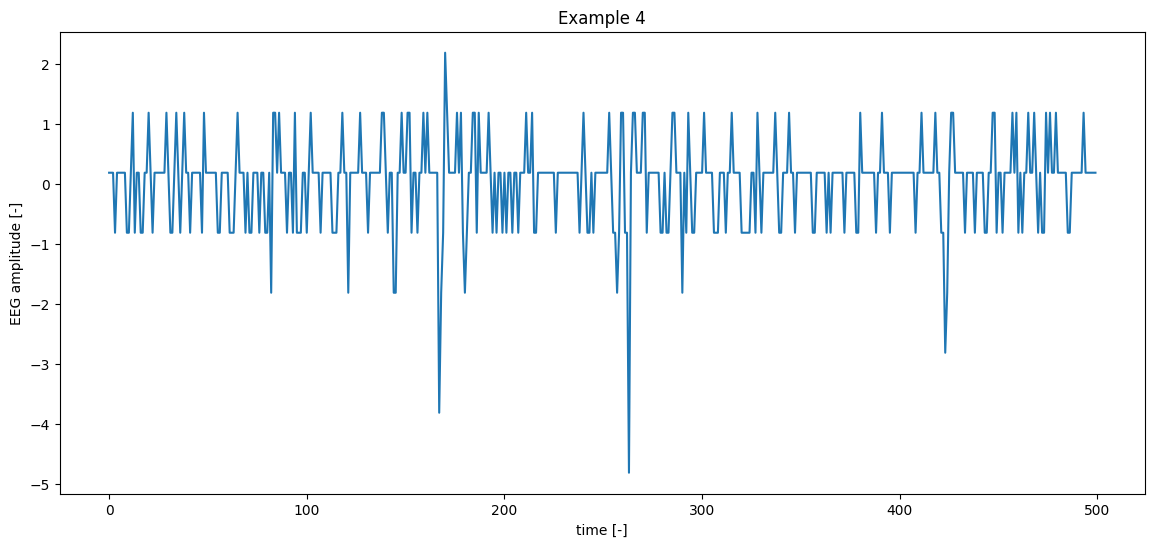

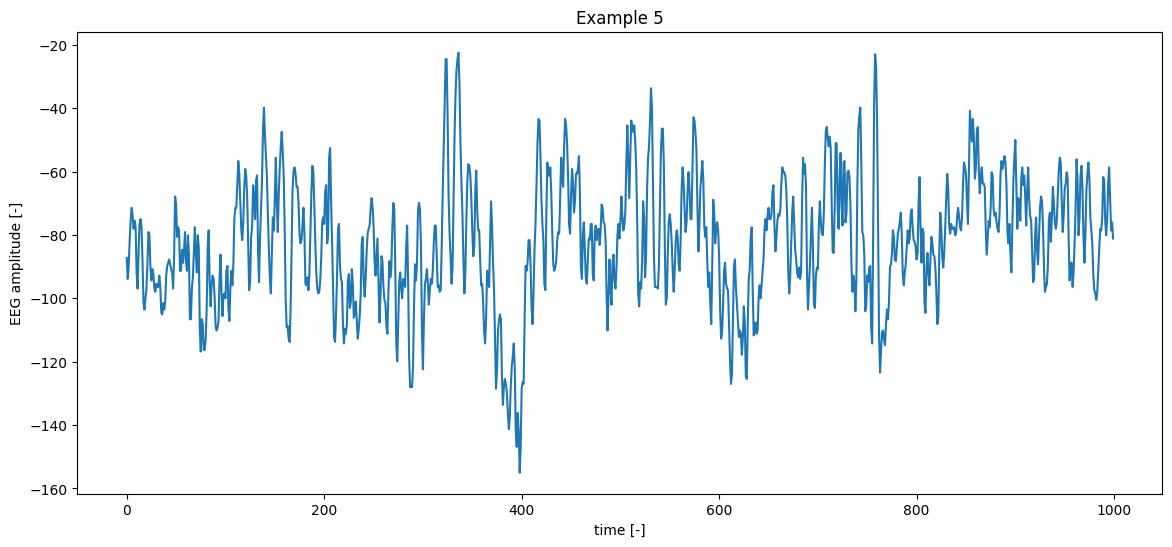

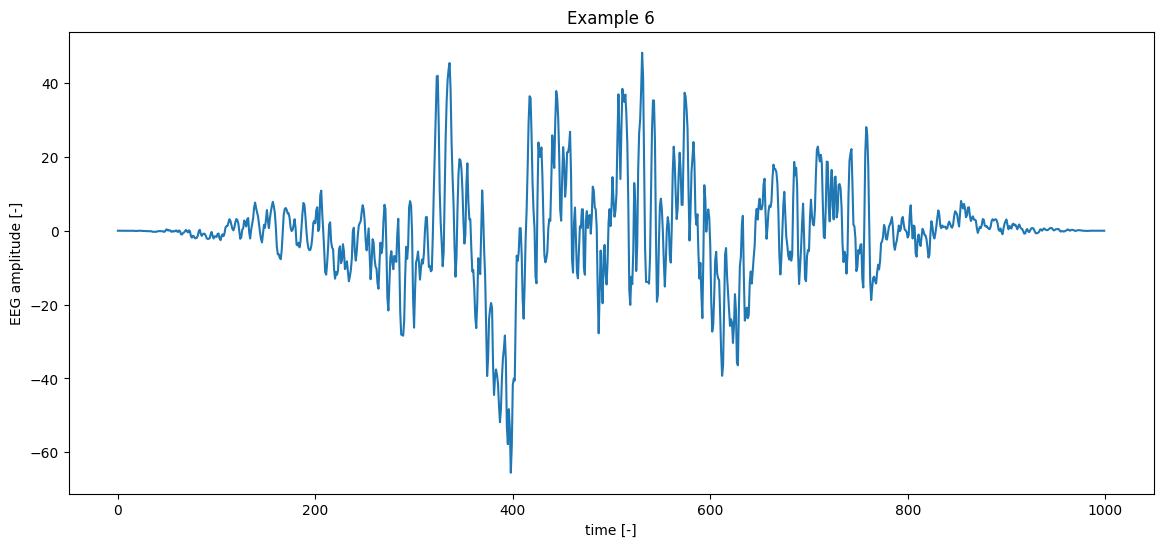

In [364]:
def plot_dataframes(dataframes):
    for i, df in enumerate(dataframes):
        plt.figure(figsize=(14, 6))
        plt.plot(df['time'], df['EEG_amplitude'])
        plt.xlabel("time [-]")
        plt.ylabel("EEG amplitude [-]")
        plt.title(f"Example {i+1}")
        plt.show()

plot_dataframes(example_dataframes)

## Defining spiking neuron class

In [365]:
class SpikingNeuron:
    def __init__(self, a=0.01, b=0.2, c=-65, d=2):
        self.a = a
        self.b = b
        self.c = c
        self.d = d
        self.u = d
        self.v = c
        self.v_out = []

    def _update(self, I):
        dv = 0.04 * self.v * self.v + 5 * self.v + 140 - self.u + I
        du = self.a * (self.b * self.v - self.u)
        self.v = self.v + dv
        self.u = self.u + du

    def transform(self, values):
        self.u = self.d
        self.v = self.c
        self.v_out = []
        for I in values:
            self._update(I)
            if self.v > 30:
                self.u = self.u + self.d
                self.v_out.append(30)
                self.v = self.c
            else:
                self.v_out.append(self.v)
        return self.v_out

# Simulating neuron firings

## Different preprocessing

### Raw data

In [366]:
# Selecting input
I_in = df1["EEG_amplitude"]
# Creating neuron
neuron = SpikingNeuron()

In [367]:
v_out = neuron.transform(I_in)

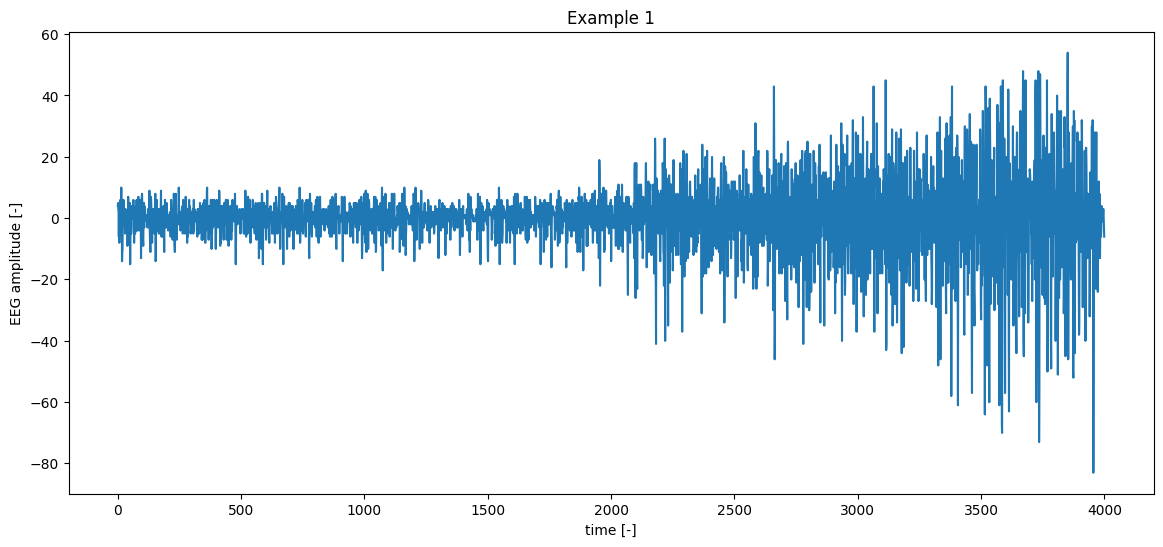

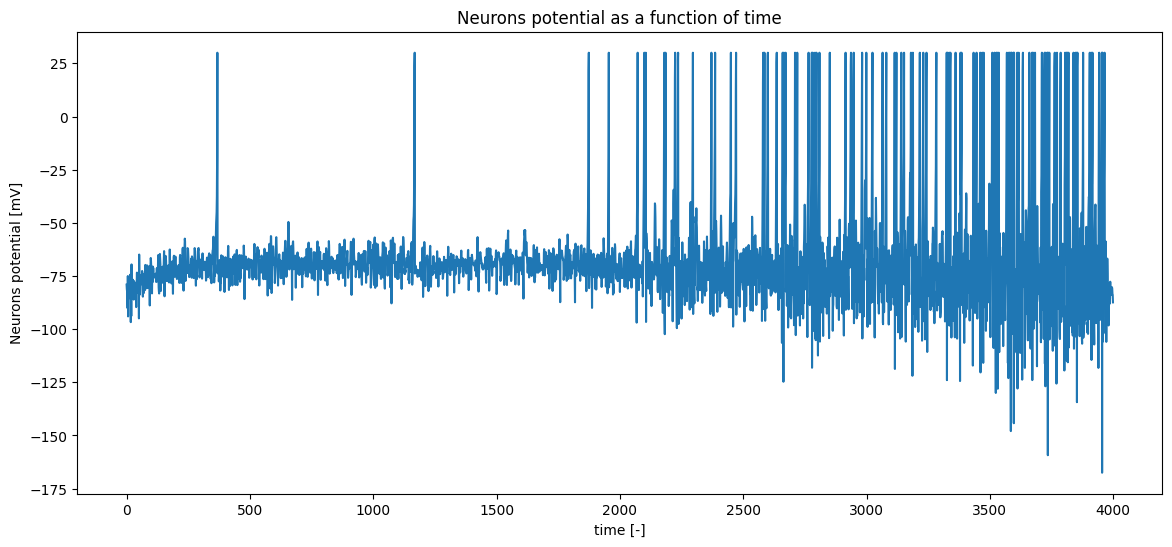

In [368]:
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(range(0, len(I_in)), I_in)
ax.set_xlabel("time [-]")
ax.set_ylabel("EEG amplitude [-]")
ax.set_title("Example 1")
plt.show()

figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(v_out)
ax.set_xlabel("time [-]")
ax.set_ylabel("Neurons potential [mV]")
ax.set_title("Neurons potential as a function of time")
plt.show()

### Rectified data

In [369]:
df1["EEG_amplitude"] = df1["EEG_amplitude"] - df1["EEG_amplitude"].mean() # removing constant component so it levels at 0
df1["EEG_amplitude"] = abs(df1["EEG_amplitude"]) # rectifying the signal

In [370]:
# Selecting input
I_in = df1["EEG_amplitude"]
# Creating neuron
neuron = SpikingNeuron()

In [371]:
v_out = neuron.transform(I_in)

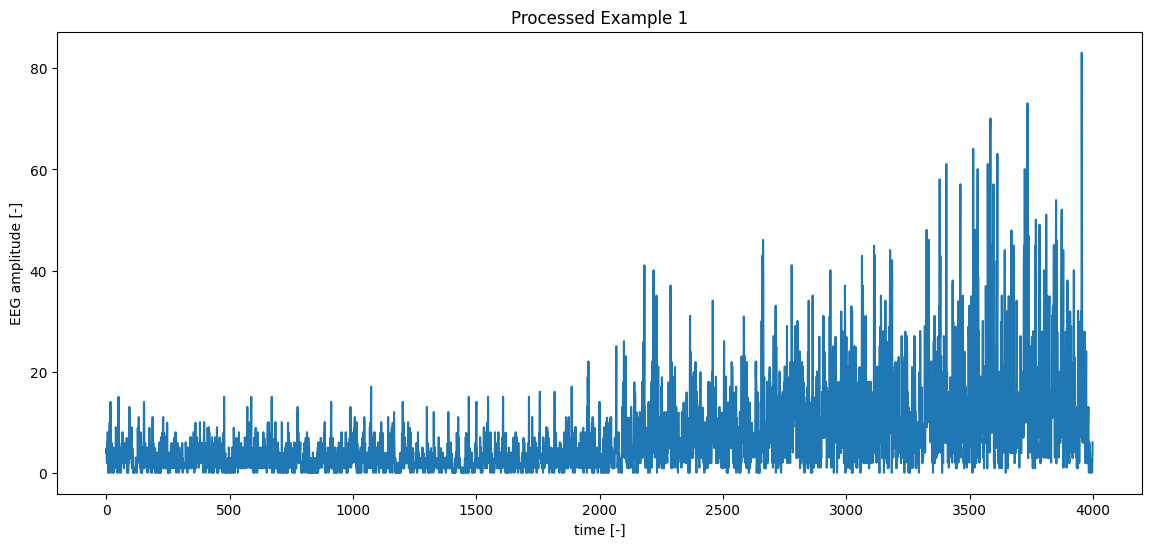

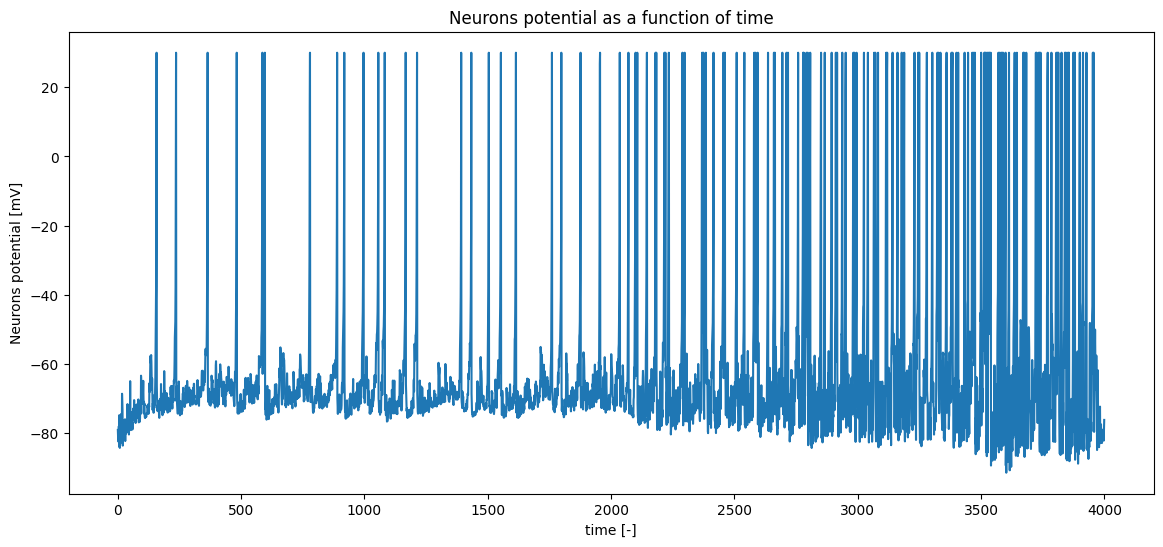

In [372]:
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(range(0, len(I_in)), I_in)
ax.set_xlabel("time [-]")
ax.set_ylabel("EEG amplitude [-]")
ax.set_title("Processed Example 1")
plt.show()

figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(v_out)
ax.set_xlabel("time [-]")
ax.set_ylabel("Neurons potential [mV]")
ax.set_title("Neurons potential as a function of time")
plt.show()

**Interpretation**: Here we can see different effect of transforming EEG signal by neuron. On raw data spikes seems to be noised by negative amplitude of the signal. Rectified data produce nice, clean spikes. Here we have example when we see a rise of neuron firings.

## Different parameters

### Parameter a

In [373]:
a_list = [0.001, 0.002, 0.01, 0.05]
neuron_list = []
for a in a_list:
    neuron_list.append(SpikingNeuron(a=a))

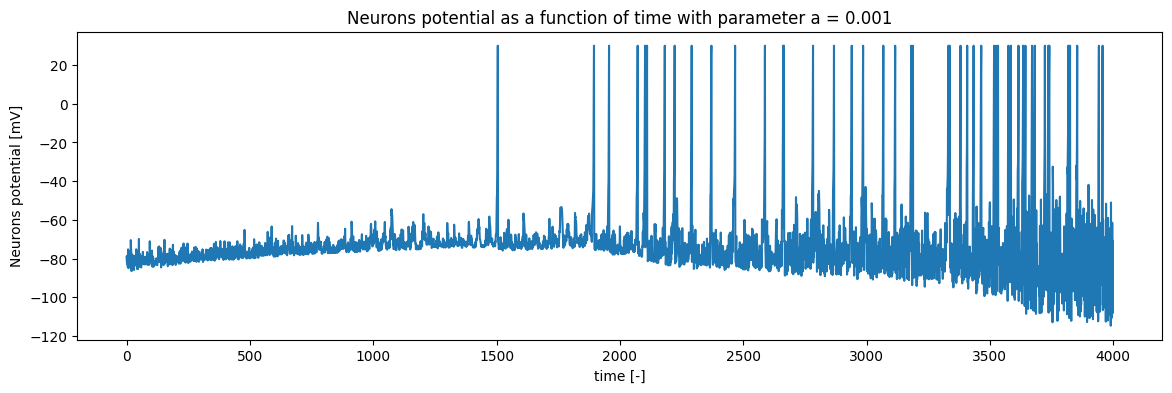

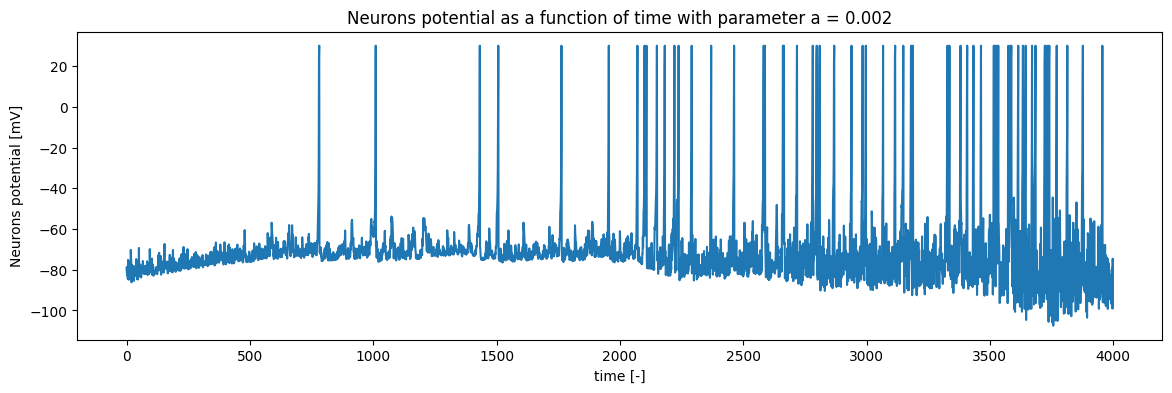

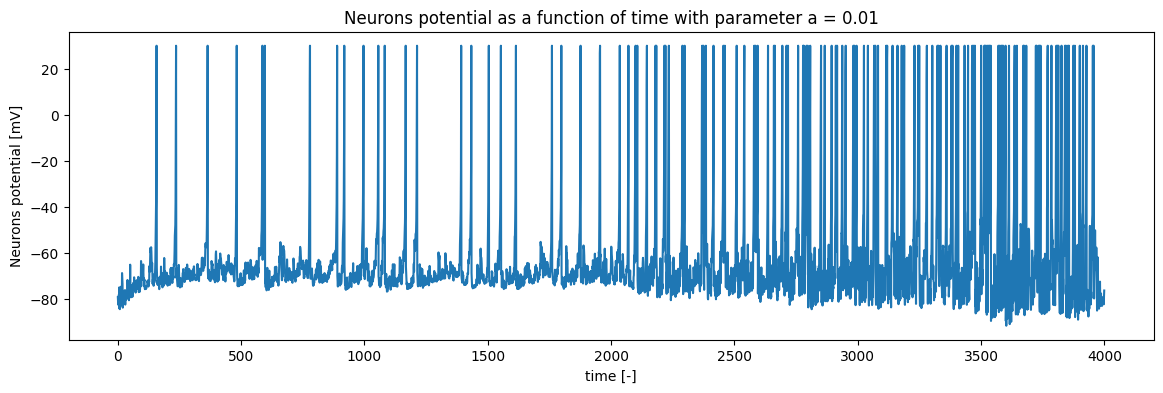

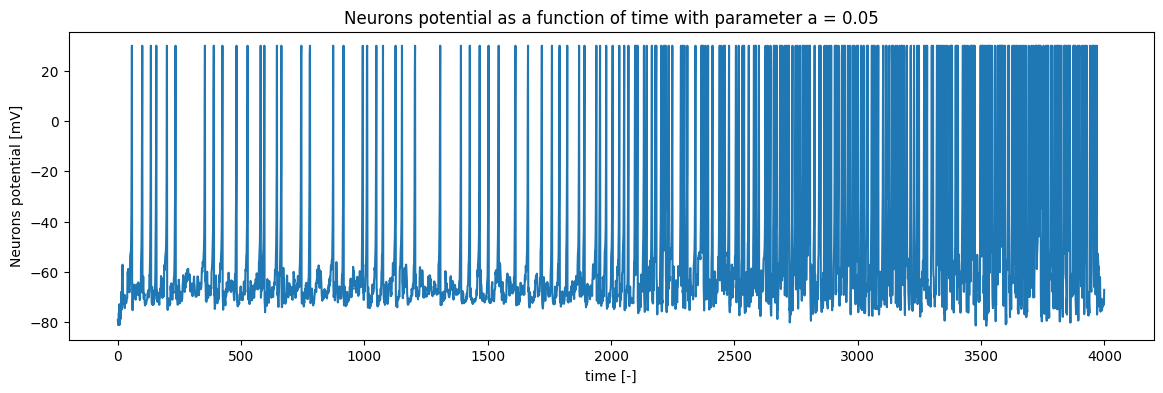

In [374]:
for neuron in neuron_list:
    figure = plt.figure(figsize=(14,4))
    ax = plt.gca()
    ax.plot(neuron.transform(I_in))
    ax.set_xlabel("time [-]")
    ax.set_ylabel("Neurons potential [mV]")
    ax.set_title("Neurons potential as a function of time with parameter a = {}".format(neuron.a))
    plt.show()

**Interpretation**: Varying *a* parameter while *b, c, d* are constant. *A* describes time scale of the recovery variable u. Smaller a means slower recovery. It is visible on first graph, with very small value, the potential struggles to rise to first spike. In last we observe huge rise of spikes in second half, where force is bigger. In the first half the frequency of firing varies as A changes. Some noise is picked up as a neuron firing and the time of recovery changes. Conclusion is that *a* can be understood and used as **how fast the frequency increases with increase of force.** This will be useful in aplication, where we need to adjust frequencies of neuron firings to different levels of EEG amplitudes to our needs.

### Parameter b

In [375]:
b_list = [0.05, 0.1, 0.2, 0.4]
neuron_list = []
for b in b_list:
    neuron_list.append(SpikingNeuron(b=b))

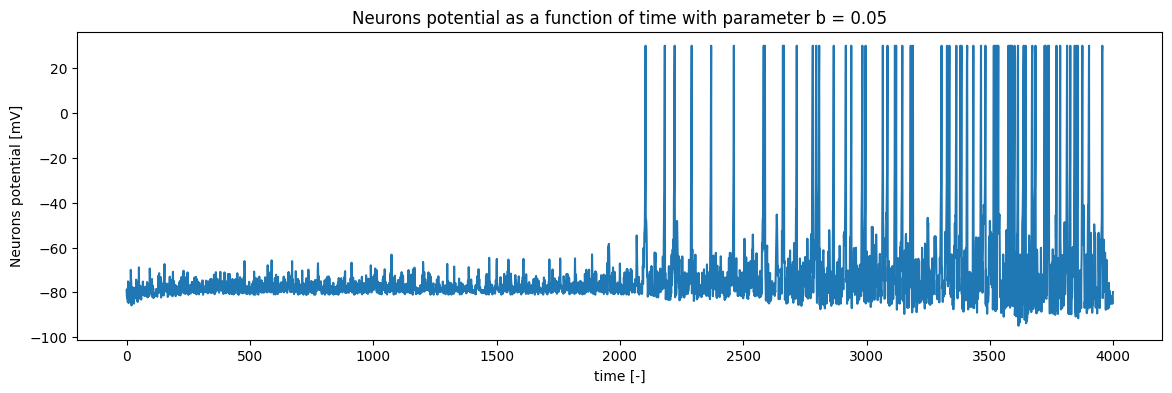

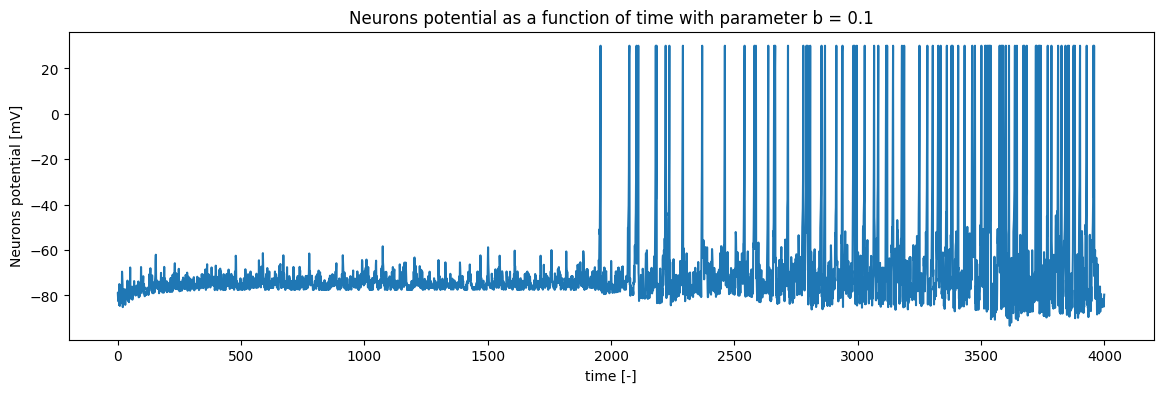

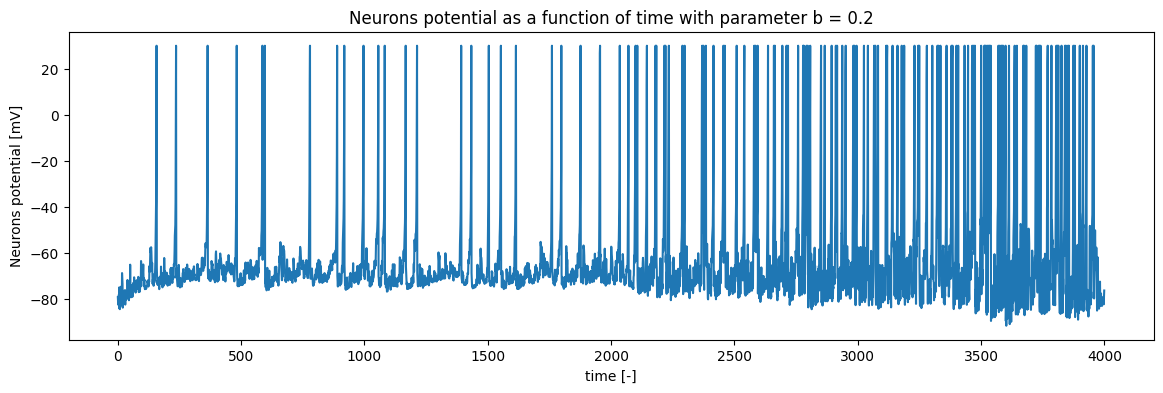

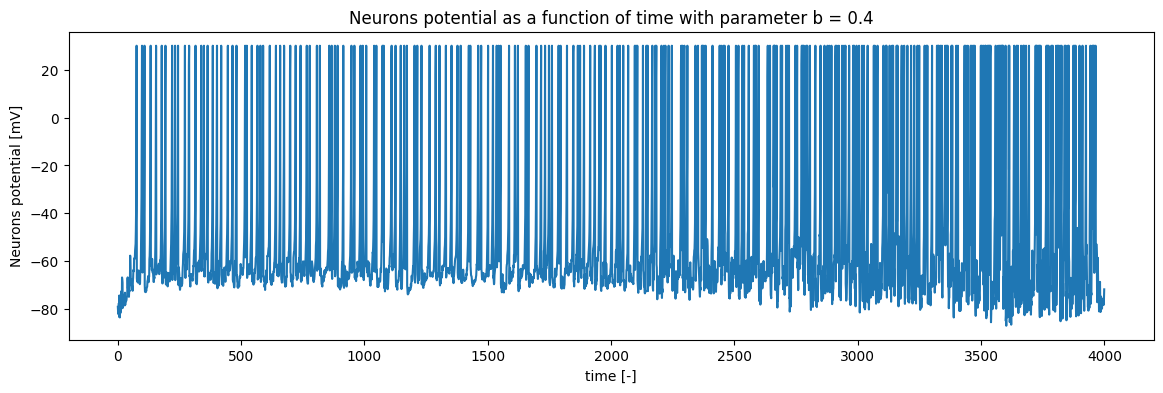

In [376]:
for neuron in neuron_list:
    figure = plt.figure(figsize=(14,4))
    ax = plt.gca()
    ax.plot(neuron.transform(I_in))
    ax.set_xlabel("time [-]")
    ax.set_ylabel("Neurons potential [mV]")
    ax.set_title("Neurons potential as a function of time with parameter b = {}".format(neuron.b))
    plt.show()

**Interpretation**: Varying parameter b. Describes sensitivity of the recovery variable u to the subthreshold fluctuations of membrane potential v. Bigger b couples v and u more. What it means is it's easier for neuron to spike. This can be used for threshold detection. Bigger b means lower threshold of force. This can be easily seen in b= 0.4, where even a small spikes in the signal cause the neuron to fire.

### Parameter d

In [377]:
d_list = [0.1, 1, 5]
neuron_list = []
for d in d_list:
    neuron_list.append(SpikingNeuron(d=d))

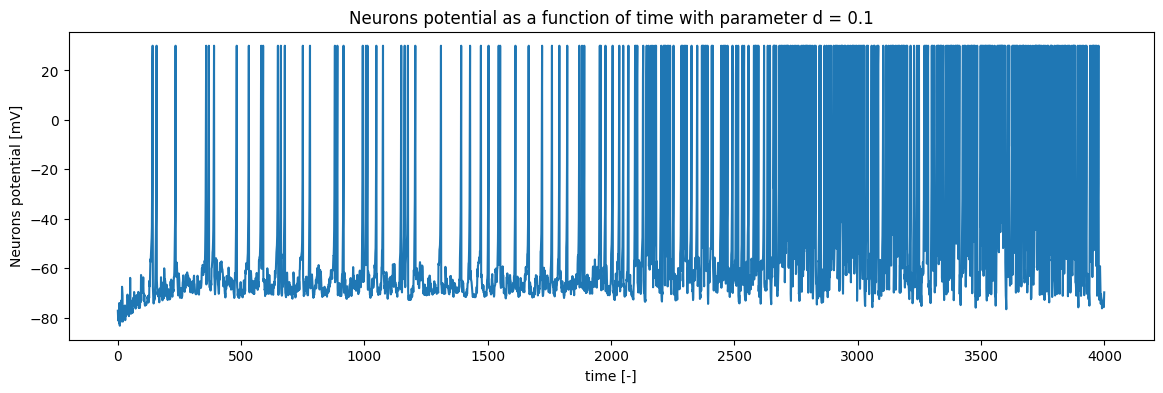

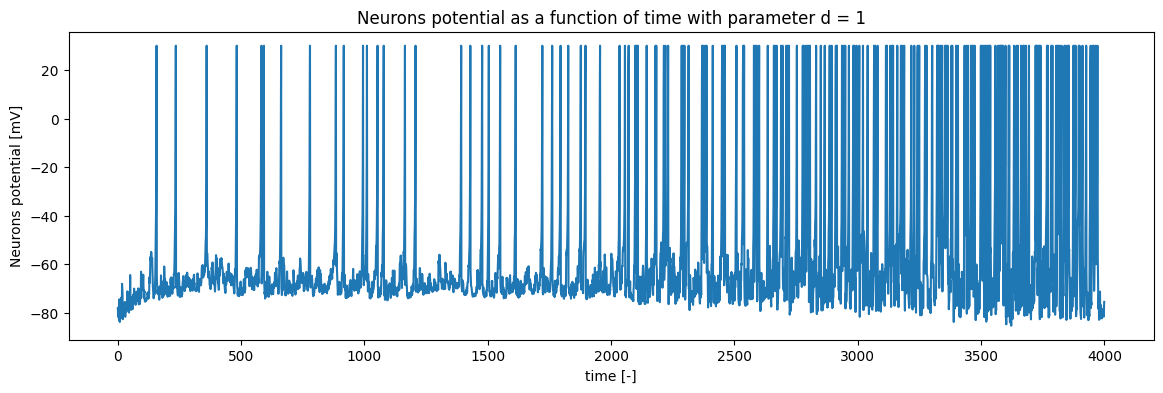

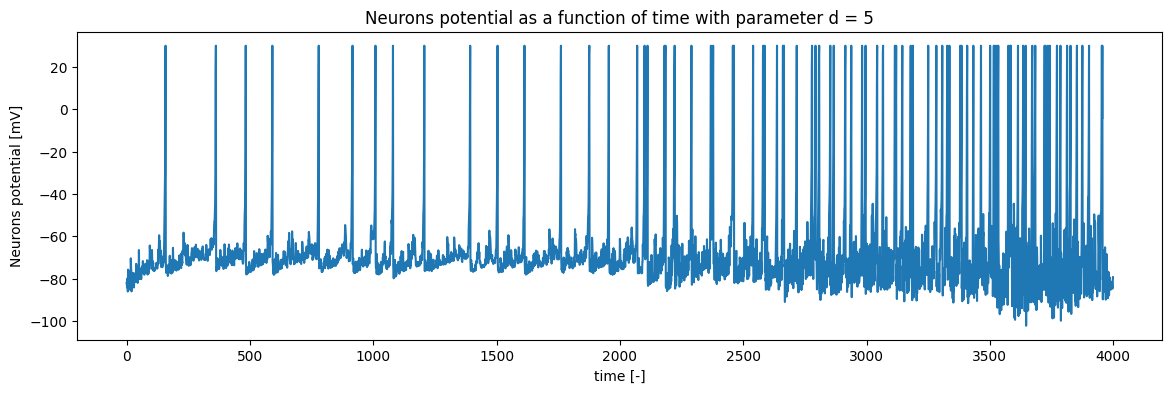

In [378]:
for neuron in neuron_list:
    figure = plt.figure(figsize=(14,4))
    ax = plt.gca()
    ax.plot(neuron.transform(I_in))
    ax.set_xlabel("time [-]")
    ax.set_ylabel("Neurons potential [mV]")
    ax.set_title("Neurons potential as a function of time with parameter d = {}".format(neuron.d))
    plt.show()

**Interpretation**: Variable *u*. It is responsible for reset after spike and recovery. Bigger value means it takes more time for neuron to spike again. Very similiar function to *a*. The difference is, at high levels of *d* the spikes are produced even with very low force, while very small *a* caused neron to struggle to rise to the first spike.

**Warning:** Too high value of u will cause huge amount of spikes!!!

## Neuron firing spikes as intensity control

### Frame preparation

In [379]:
# Parameters
sampling = 650  # frequency of sampling, in Hz
t_frame = 0.2   # time of one frame, in seconds
t_hop = 0.2     # shift between frames, in seconds

# Calculated parameters
frame_size = int(sampling * t_frame)  # number of samples per frame
hop_size = int(sampling * t_hop)      # number of samples to shift per step

# Lists to store frames
frames_list = []

# Loop through the data, extracting frames
for i in range(0, len(df) - frame_size, hop_size):
    eeg_frame = df["EEG_amplitude"].values[i:i + frame_size]
    frames_list.append(eeg_frame)

# Convert the lists to numpy arrays
frames = np.asarray(frames_list).reshape(-1, frame_size)

# Output the shapes of the resulting arrays for verification
frames.shape

(7, 130)

### Comparing RMS and Number-of-Spikes

In [380]:
rms_list = []
for frame in frames:
    rms = np.sqrt(np.mean(frame**2))
    rms_list.append(rms)

In [381]:
spikes_list = []
neuron = SpikingNeuron()
for frame in frames:
    v_out = neuron.transform(frame)
    v_out = np.asarray(v_out)
    #print(np.where(v_out > 29))
    nspikes = np.count_nonzero(v_out > 29)
    spikes_list.append(nspikes)

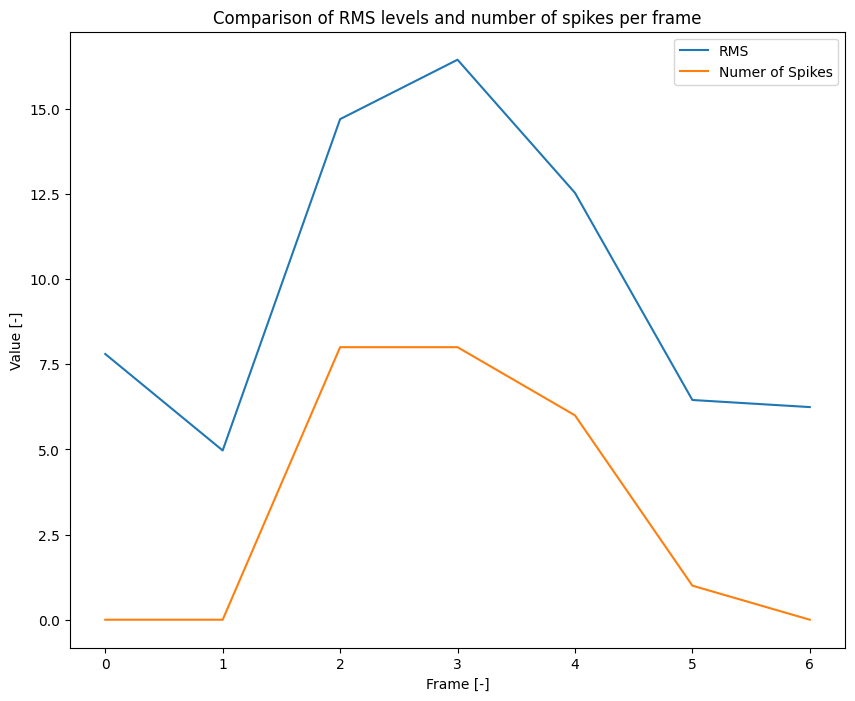

Correlation of RMS and Number-of-Spikes is 97.32%


In [382]:
figure = plt.figure(figsize=(10,8))
ax = plt.gca()
ax.plot(rms_list)
ax.plot(spikes_list)
ax.set_xlabel("Frame [-]")
ax.set_ylabel("Value [-]")
ax.legend(["RMS", "Numer of Spikes"])
ax.set_title("Comparison of RMS levels and number of spikes per frame")
plt.show()
print("Correlation of RMS and Number-of-Spikes is {0:.2f}%".format(np.corrcoef(rms_list, spikes_list)[0][1]*100))

**Interpretation**: Here I took a couple of frames, calculated RMS for every of them and calculated amount of spikes per frame. It looks like number of spikes is significantly correlated to RMS, which means that spikes can be treated as an alternative to PWM or RMS as a intensity control.

## Modeling nerve bundle

In [397]:
# Selecting input
I_in = df1["EEG_amplitude"]
# Setting neuron parameters:
S1_neuron = SpikingNeuron(a=0.01 + np.random.randint(1,100)/10000,
                          b=0.2 + np.random.randint(1,100)/1000,
                          d=2 + np.random.randint(1,100)/100)
S2_neuron = SpikingNeuron(a=0.01 + np.random.randint(1,100)/10000,
                          b=0.2 + np.random.randint(1,100)/1000,
                          d=2 + np.random.randint(1,100)/100)
FR1_neuron = SpikingNeuron(a=0.01 + np.random.randint(1,100)/1000,
                          b=0.1 + np.random.randint(1,100)/1000,
                          d=2 + np.random.randint(1,100)/100)
FR2_neuron = SpikingNeuron(a=0.01 + np.random.randint(1,100)/1000,
                          b=0.1 + np.random.randint(1,100)/1000,
                          d=2 + np.random.randint(1,100)/100)
FF1_neuron = SpikingNeuron(a=0.001 + np.random.randint(1,100)/10000,
                          b=0.01 + np.random.randint(1,100)/1000,
                          d=2)

neuron_list = [S1_neuron, S2_neuron, FR1_neuron, FR2_neuron, FF1_neuron]

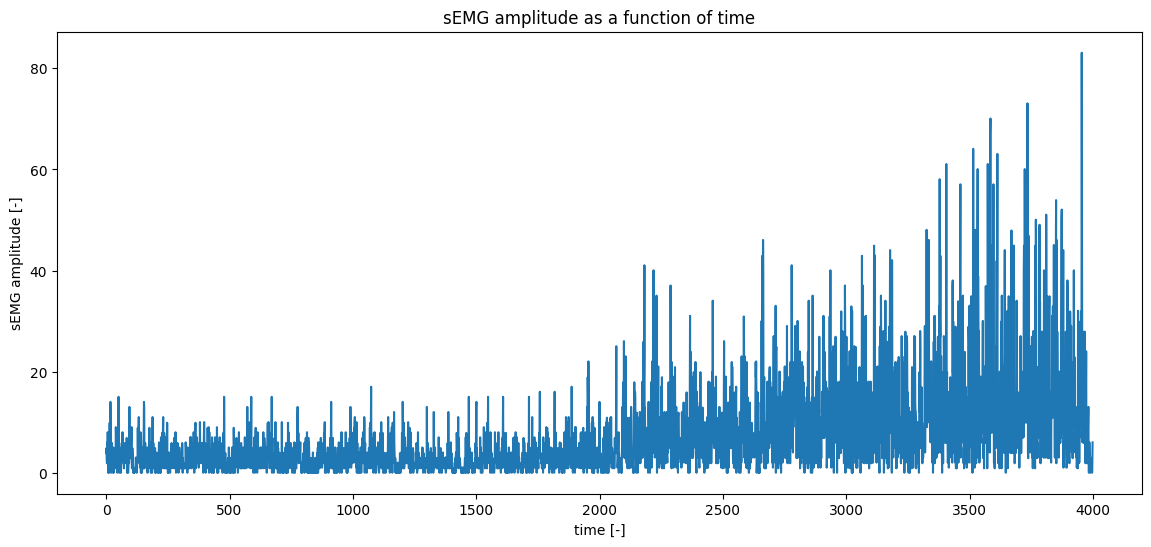

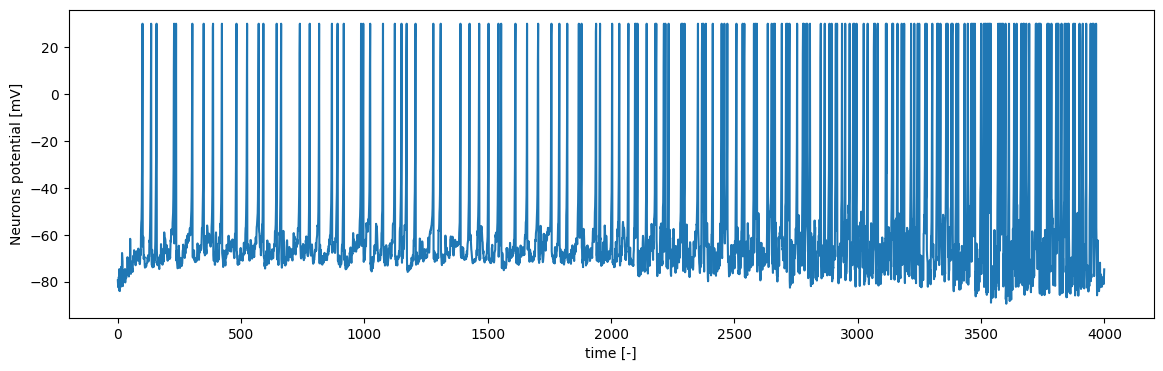

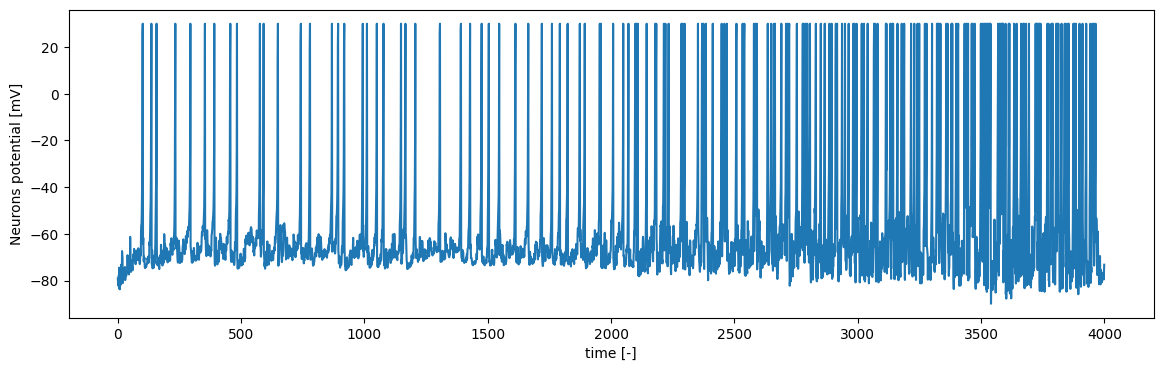

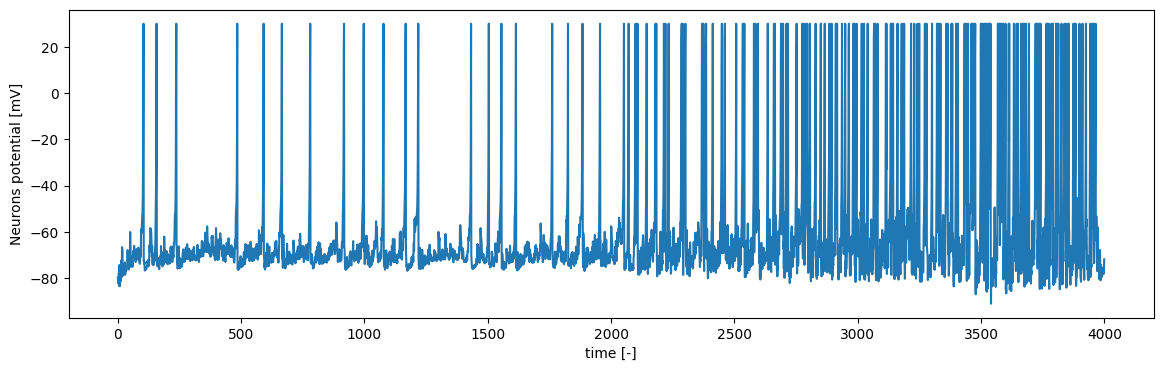

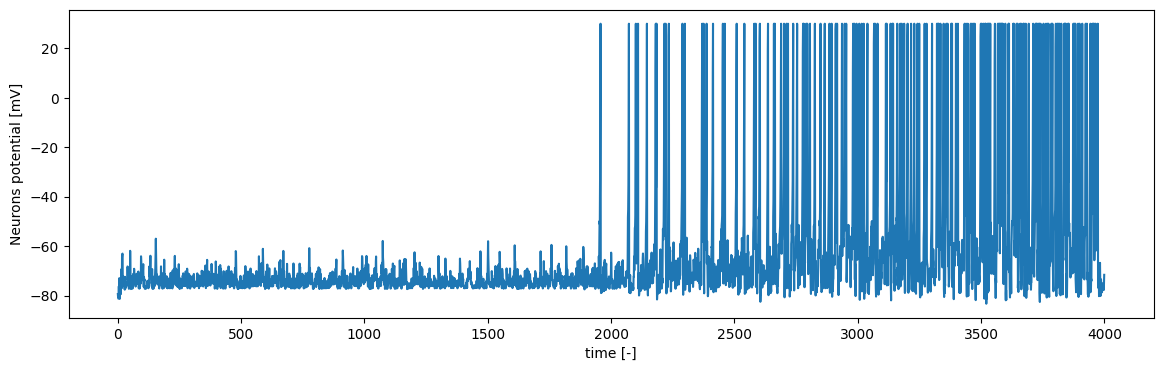

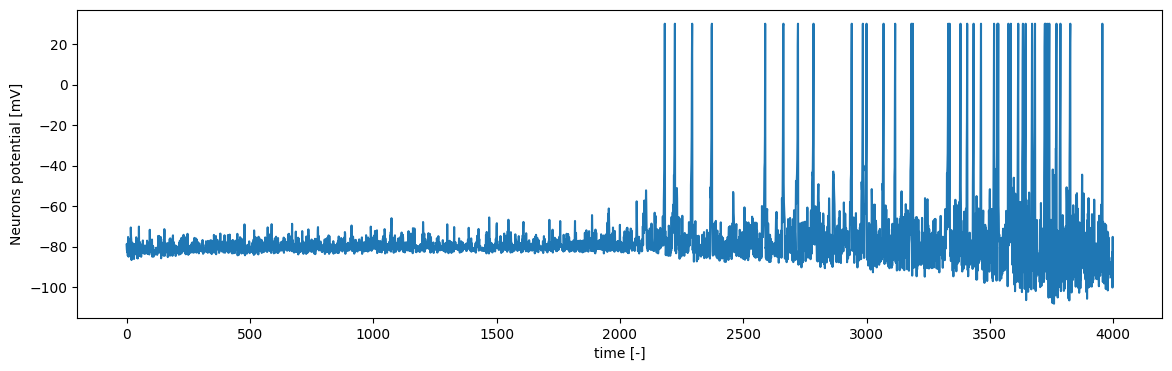

In [398]:
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(range(0, len(I_in)), I_in)
ax.set_xlabel("time [-]")
ax.set_ylabel("EEG amplitude [-]")
ax.set_title("EEG amplitude as a function of time".format("column"))
plt.show()

for neuron in neuron_list:
    figure = plt.figure(figsize=(14,4))
    ax = plt.gca()
    ax.plot(neuron.transform(I_in))
    ax.set_xlabel("time [-]")
    ax.set_ylabel("Neurons potential [mV]")
    plt.show()

**Interpretation**: Here I modelled a nerve bunch made out of 5 different neuron units. First two are smaller and more sensitive units firing whenever there is even a smallest stimulus. The next two are intermediate, firing maybe a little at the beggining but with bigger force firing up. Last one is biggest, fatiguable one which produces the most force per spike. It fires only when rarely and only are neccesary.

The point of this experiment is to show not only different behaviours but also that we can have infinitely differently modeled neurons which spikes does not overlap. Their behaviour are however binded, or one might say, connected by the intensity of stimuli. We can model 3, we can model 10 or 100. The biggest question is how can we use that for our purposes. One idea is to treat each spike of a neuron as a "call to action". It moves and electric engine a little bit with a little bit momentum. More spikes mean more movement, more focus, bigger emotional reaction. This also allows to treat the brain as universal controller. When every neuron can be associated as a button and it's every spike associated as pressing the said button it could allow for some learning curve and in the end controlling computer like a keyboard.

## Replicating neuron firings

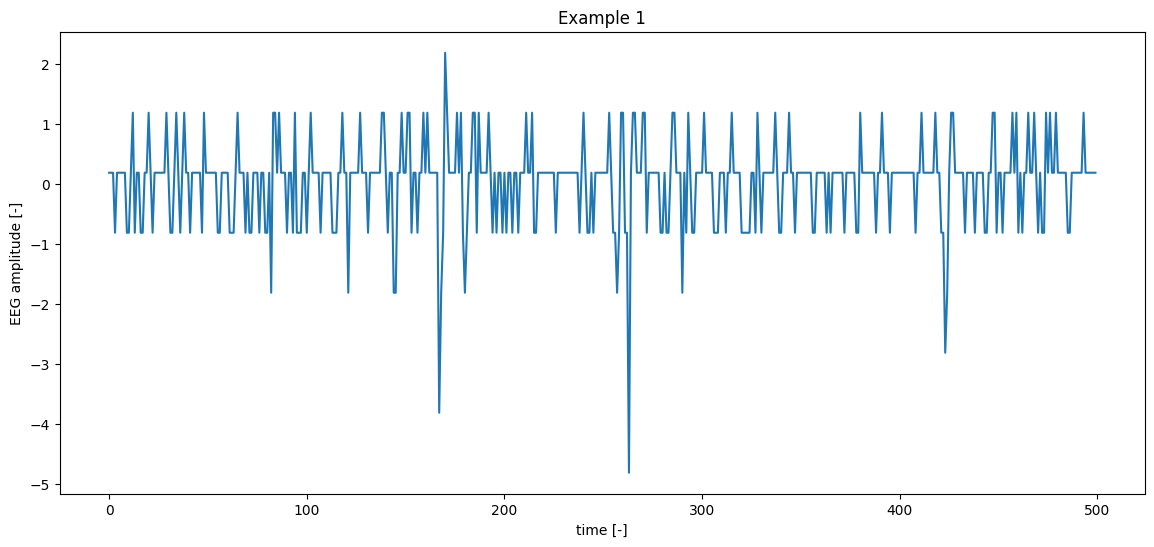

In [399]:
# Selecting input
I_in = df4["EEG_amplitude"]
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(range(0, len(I_in)), I_in)
ax.set_xlabel("time [-]")
ax.set_ylabel("EEG amplitude [-]")
ax.set_title("Example 1")
plt.show()

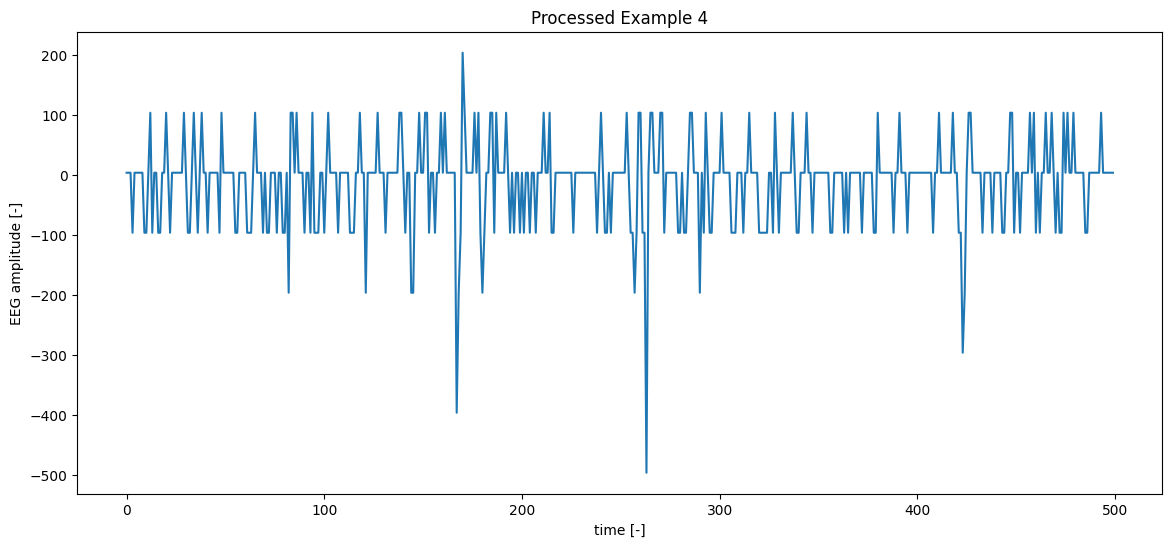

In [400]:
I_in = df4["EEG_amplitude"]*100 - 14.4 # Due to low amplitude, I've increased amplitude 100 times and removed manually mean to make 0 equal to realistic 0
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(range(0, len(I_in)), I_in)
ax.set_xlabel("time [-]")
ax.set_ylabel("EEG amplitude [-]")
ax.set_title("Processed Example 4")
plt.show()

In [401]:
S1_neuron = SpikingNeuron(a=0.01,
                          b=1,
                          c = -50,
                          d=2)
v_out = np.asarray(S1_neuron.transform(I_in))

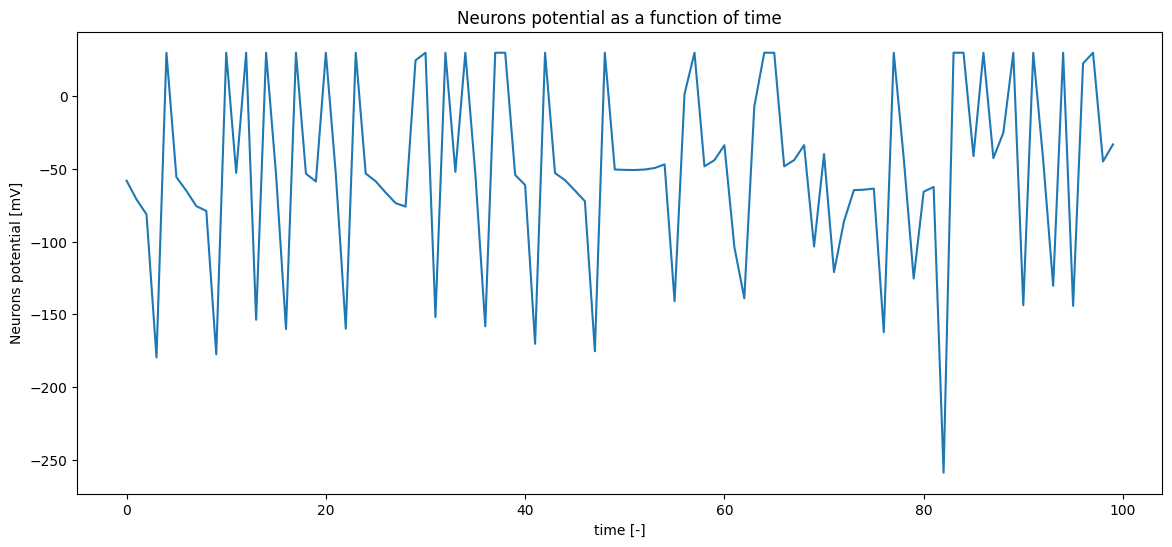

In [402]:
figure = plt.figure(figsize=(14,6))
ax = plt.gca()
ax.plot(v_out[:100])
ax.set_xlabel("time [-]")
ax.set_ylabel("Neurons potential [mV]")
ax.set_title("Neurons potential as a function of time")
plt.show()

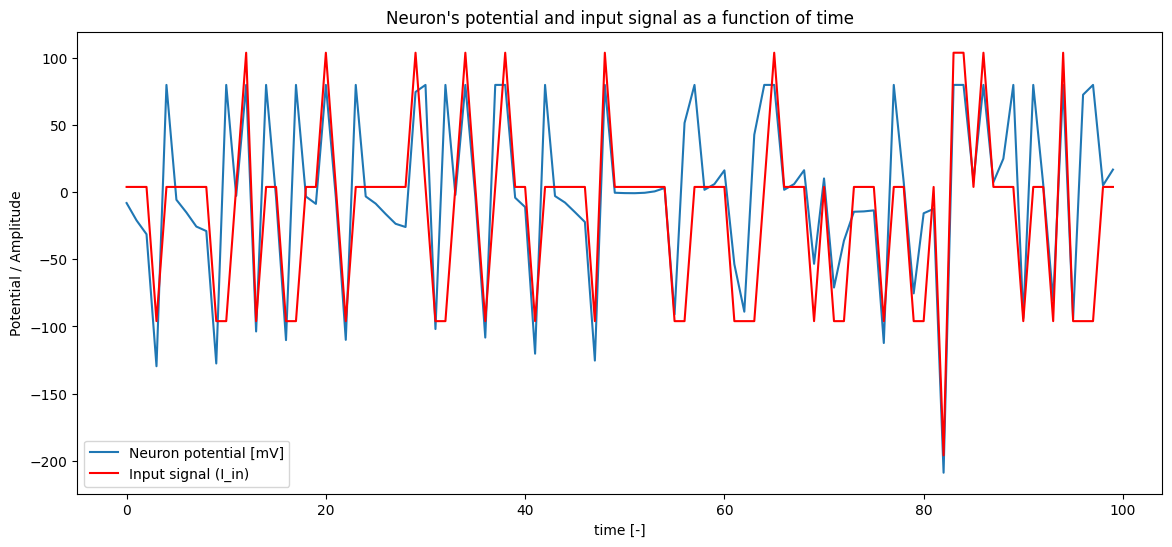

In [403]:
# Assuming v_out and I_in are already defined
figure = plt.figure(figsize=(14,6))
ax = plt.gca()

# Plotting the neuron's potential (v_out)
ax.plot(np.asarray(v_out[:100])+50, label='Neuron potential [mV]')

# Plotting the input signal (I_in) in red
ax.plot(I_in[:100], color='red', label='Input signal (I_in)')

# Setting labels and title
ax.set_xlabel("time [-]")
ax.set_ylabel("Potential / Amplitude")
ax.set_title("Neuron's potential and input signal as a function of time")

# Adding a legend to differentiate the plots
ax.legend()

# Display the plot
plt.show()

**Interpretation**: Here I've played a little bit with parameters to recreate a neuron firing pattern of a given signal. This could give us more insight into what is actually happening inside, for example showing us firing that couldn't be detected by the sensor. In some cases the electrode sampling rate might restrict capabilities of fully visualising firing signal. Of course, in my case calibration of parameters could be a little bit better, perhaps a machine learning algorithm could adjust them and optimize them better. Still, this model shows a big potential.

# Conclusion

In this notebook I have modeled neurons firing patterns with different parameters based on EEG signals. I've shown theory on how cortal neuron operates, mathematical algorithm for producing firings and explained all variables. The model has been contained in a single class called SpikingNeuron. It's parameters can be set at definitions or left blank (they will be set to default values). It has two methods: _update which is private method used to update recovery variable u and voltage at current time v. Method transform takes a list of datapoints, performs right calculations and returns a list of potential values of neuron with spikes.

In section "Simulating neuron firings" I've visualised different behaviours based on:
- Data
    - raw,
    - rectified,
- Parameters
    - a,
    - b,
    - d.

For more information about parameters and behavior please refer to the intro section "Mathematical neuron model".

Next, a nerve bundle made out of 5 neurons have been modeled. It is opening doors to many more ideas such as using neurons as a features in machine learning models, using them as threshhold and it brings us closer to fuller, better decomposition of EEG signal for more precise control.

Finally, I've tried to recreate a firing pattern of a recorded signal by using spiking neuron model. I've accomplished partial succes, as the model could be more precisely calibrated.